In [101]:
import pandas as pd 
import numpy as np 
import math
import matplotlib.pyplot as plt 


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Flatten, TimeDistributed,ConvLSTM2D
from keras.layers.convolutional import Conv1D,MaxPooling1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from TimeSeries import series_to_supervised,create_differencing_reverse,differencing,evaluate_model,plot_result, evaluate_multistep_model,plot_multistep_result


%matplotlib inline

In [2]:
data=pd.read_csv("archive\GOOGL_2006-01-01_to_2018-01-01.csv")
data.drop(['Name','Open','High','Low'],inplace=True,axis=1)
data.set_index('Date',inplace=True)
data.index=pd.to_datetime(data.index)
data

,Close,Volume
Date,,
2006-01-03,217.83,13137450
2006-01-04,222.84,15292353
2006-01-05,225.85,10815661
2006-01-06,233.06,17759521
2006-01-09,233.68,12795837
...,...,...
2017-12-22,1068.86,889446
2017-12-26,1065.85,918767
2017-12-27,1060.20,1116203


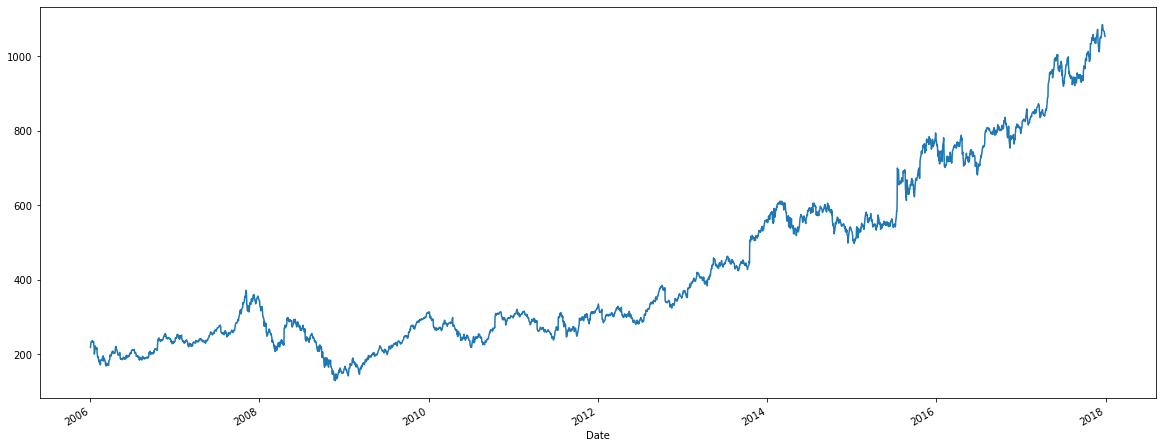

In [3]:
plt.figure( figsize=(20, 8))
data['Close'].plot()
plt.show()

# Stationarity

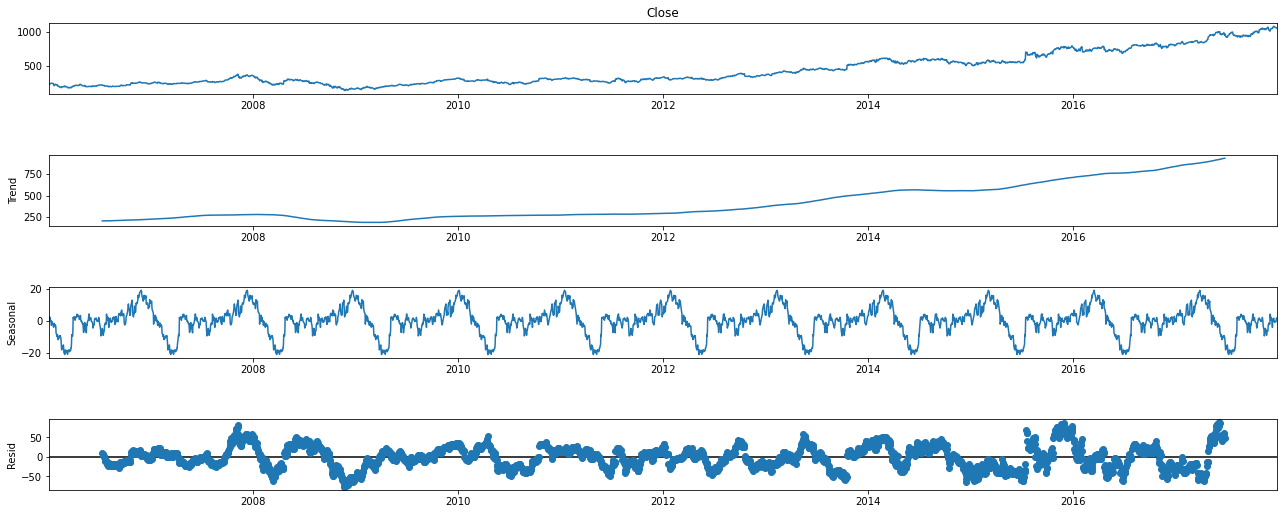

In [4]:
a = seasonal_decompose(data['Close'], model = "add",period=5*52)
fig=a.plot();
fig.set_figheight(8)
fig.set_figwidth(20)

In [5]:
dftest = adfuller(data['Close'], autolag = 'AIC')
print("P-Value :  %.7f " %(dftest[1]))

P-Value :  0.9967316 


In [6]:
differencing(data,['Close'])
data

,Close,Volume,Close_diff
Date,,,
2006-01-03,217.83,13137450,NaN
2006-01-04,222.84,15292353,5.01
2006-01-05,225.85,10815661,3.01
2006-01-06,233.06,17759521,7.21
2006-01-09,233.68,12795837,0.62
...,...,...,...
2017-12-22,1068.86,889446,-1.99
2017-12-26,1065.85,918767,-3.01
2017-12-27,1060.20,1116203,-5.65


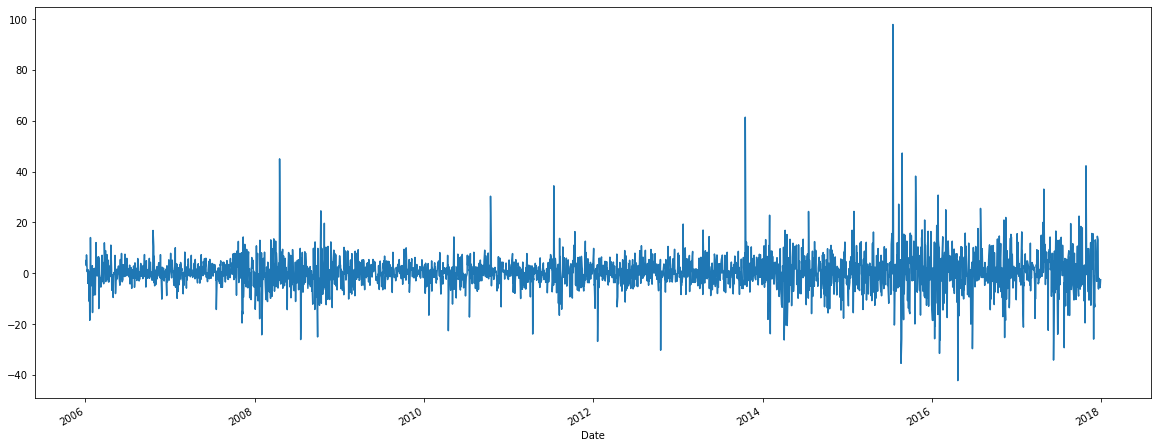

In [7]:
plt.figure( figsize=(20, 8))
data['Close_diff'].plot()
plt.show()

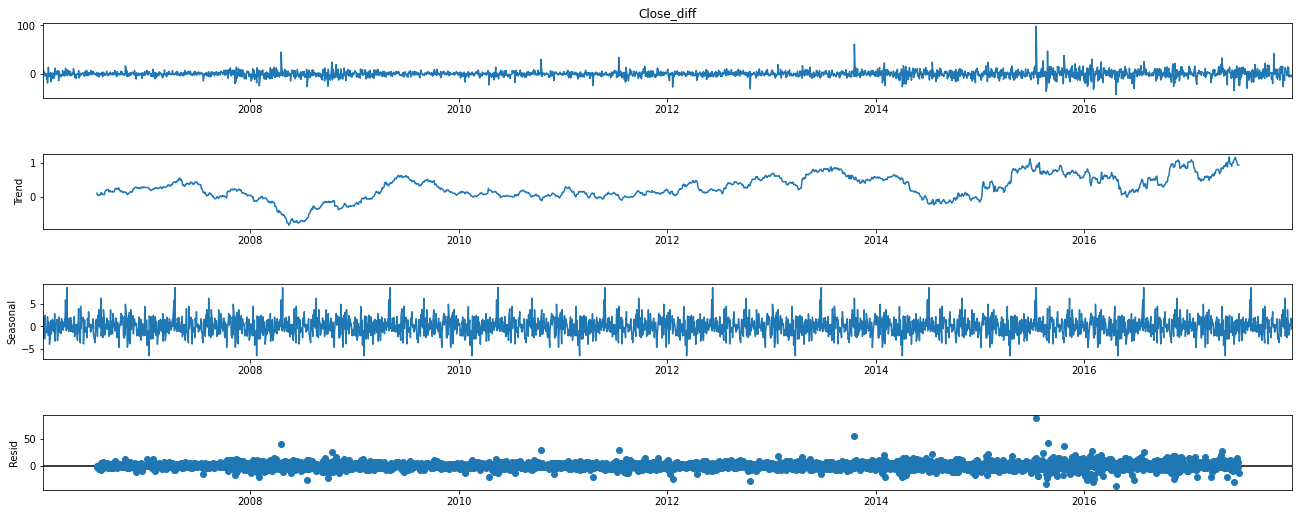

In [8]:
a = seasonal_decompose(data['Close_diff'][1:], model = "add",period=5*52)
fig=a.plot();
fig.set_figheight(8)
fig.set_figwidth(20)

In [9]:
dftest = adfuller(data['Close_diff'][1:], autolag = 'AIC')
print("P-Value :  %.7f " %(dftest[1]))

P-Value :  0.0000000 


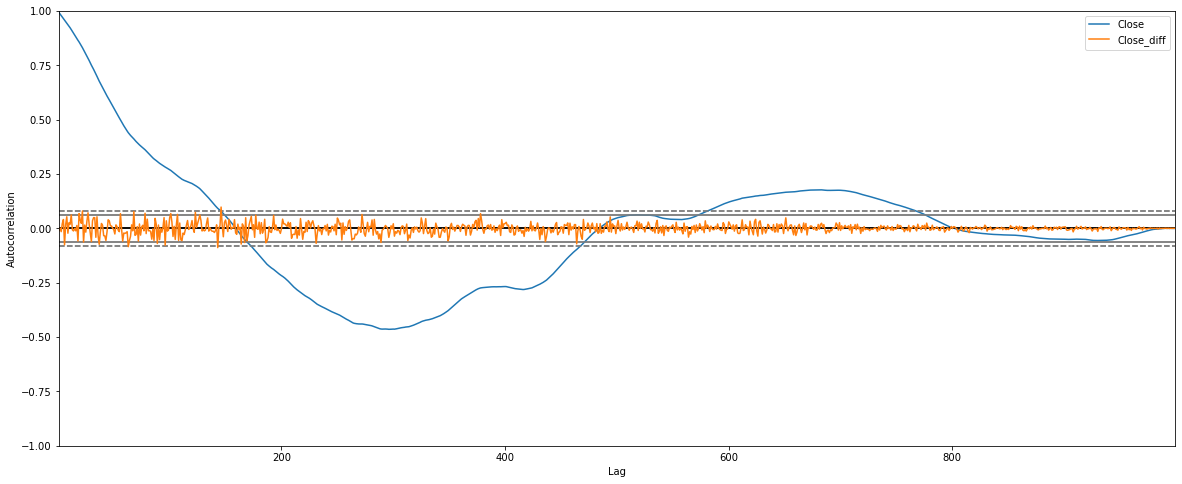

In [10]:
plt.figure( figsize=(20, 8))
pd.plotting.autocorrelation_plot(data['Close'][1:1000],label='Close')
pd.plotting.autocorrelation_plot(data['Close_diff'][1:1000],label='Close_diff');

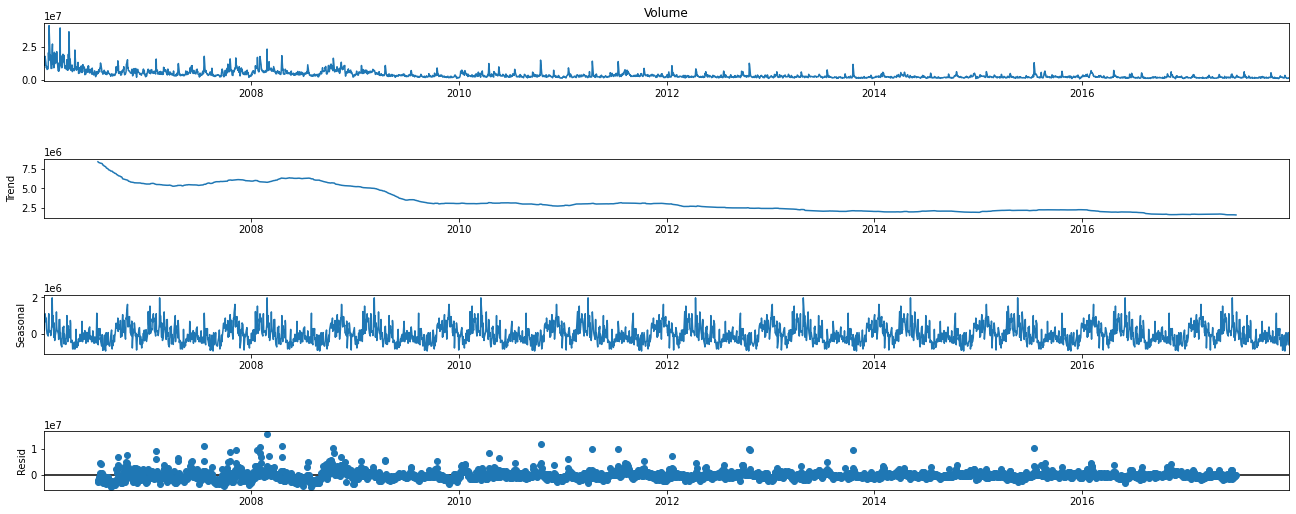

In [11]:
a = seasonal_decompose(data['Volume'], model = "add",period=5*52)
fig=a.plot();
fig.set_figheight(8)
fig.set_figwidth(20)

In [12]:
dftest = adfuller(data['Volume'], autolag = 'AIC')
print("P-Value :  %.7f " %(dftest[1]))

P-Value :  0.0000007 


In [13]:
test_data=pd.read_csv("archive\GOOG.csv")
test_data.set_index('Date',inplace=True)
test_data=test_data.loc[:,['Close','Volume']]
test_data.index=pd.to_datetime(test_data.index)
differencing(test_data,['Close'])
test_data

,Close,Volume,Close_diff
Date,,,
2018-01-02,1065.000000,1237600,NaN
2018-01-03,1082.479980,1430200,17.479980
2018-01-04,1086.400024,1004600,3.920044
2018-01-05,1102.229980,1279100,15.829956
2018-01-08,1106.939941,1047600,4.709961
...,...,...,...
2021-03-08,2024.170044,1646000,-84.369995
2021-03-09,2052.699951,1696400,28.529907
2021-03-10,2055.030029,1267800,2.330078


# Prepare data for model

In [14]:
TRAIN_TEST_SPLIT=0.8

In [15]:
train_size=int(data.shape[0]*TRAIN_TEST_SPLIT)
train_data=data[:train_size]
validate_data=data[train_size:]

In [16]:
pd.set_option('mode.chained_assignment', None)

close_scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Close_diff'][1:] = (close_scaler.fit_transform((train_data['Close_diff'][1:]).to_numpy().reshape(-1,1))).reshape(-1)
validate_data['Close_diff'][1:]=(close_scaler.transform((validate_data['Close_diff'][1:]).to_numpy().reshape(-1,1))).reshape(-1)
test_data['Close_diff'][1:]=(close_scaler.transform((test_data['Close_diff'][1:]).to_numpy().reshape(-1,1))).reshape(-1)


volume_scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Volume'] = (volume_scaler.fit_transform(train_data['Volume'].to_numpy().reshape(-1,1))).reshape(-1)
validate_data['Volume'] = (volume_scaler.transform(validate_data['Volume'].to_numpy().reshape(-1,1))).reshape(-1)
test_data['Volume'] = (volume_scaler.transform(test_data['Volume'].to_numpy().reshape(-1,1))).reshape(-1)

pd.set_option('mode.chained_assignment', 'warn')

# Reference test time series RSME

In [17]:
REF_RSME=math.sqrt(mean_squared_error(test_data['Close'].values[1:], test_data['Close'].values[:-1]))
REF_RSME

25.58367504587955

In [18]:
RSME_names=['Reference RSME']
RSME_values=[REF_RSME]

# 1. Univariate LSTM Models

In [19]:
STEPS_IN=30
STEPS_OUT=1

In [20]:
supervised_train_data=series_to_supervised(train_data.loc[:,['Close_diff']],STEPS_IN,STEPS_OUT,dropnan=True)
supervised_validate_data=series_to_supervised(validate_data.loc[:,['Close_diff']],STEPS_IN,STEPS_OUT,dropnan=True)[1:]
supervised_test_data=series_to_supervised(test_data.loc[:,['Close_diff']],STEPS_IN,STEPS_OUT,dropnan=True)

In [21]:
difference_train_data=create_differencing_reverse(train_data.loc[:,['Close']],STEPS_IN,STEPS_OUT)
difference_validate_data=create_differencing_reverse(validate_data.loc[:,['Close']],STEPS_IN,STEPS_OUT)
difference_test_data=create_differencing_reverse(test_data.loc[:,['Close']],STEPS_IN,STEPS_OUT)

In [22]:
trainX=supervised_train_data.iloc[:,:STEPS_IN].to_numpy().reshape(-1,STEPS_IN)
trainY=supervised_train_data.iloc[:,STEPS_IN:STEPS_IN+STEPS_OUT].to_numpy().reshape(-1,STEPS_OUT)

In [23]:
validateX=supervised_validate_data.iloc[:,:STEPS_IN].to_numpy().reshape(-1,STEPS_IN)
validateY=supervised_validate_data.iloc[:,STEPS_IN:STEPS_IN+STEPS_OUT].to_numpy().reshape(-1,STEPS_OUT)

In [24]:
testX=supervised_test_data.iloc[:,:STEPS_IN].to_numpy().reshape(-1,STEPS_IN)
testY=supervised_test_data.iloc[:,STEPS_IN:STEPS_IN+STEPS_OUT].to_numpy().reshape(-1,STEPS_OUT)

In [25]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validateX=np.reshape(validateX, (validateX.shape[0], 1, validateX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## 1.1 Vanilla LSTM

### 1.1.1 Unit size

In [179]:
VanilaUnitSize_df=pd.DataFrame()
units=[1,5,10,15,20]

for unit in units:
    errors=list()
    print(f'Unit {unit}')  
    for index in range(0,10):
        model = Sequential()
        model.add(LSTM(unit, input_shape=(1, STEPS_IN), return_sequences=False))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history=model.fit(trainX, trainY, epochs=200, batch_size=20,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_model(model,validateX,validateY,close_scaler,difference_validate_data))

    VanilaUnitSize_df[f'Units {unit}']=errors

Unit 1
Unit 5
Unit 10
Unit 15
Unit 20


In [180]:
VanilaUnitSize_df.describe()

,Units 1,Units 5,Units 10,Units 15,Units 20
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,9.490318,9.514960,9.516273,9.519620,9.519376
std,0.008608,0.017712,0.018837,0.017332,0.014915
min,9.477029,9.481696,9.482370,9.483436,9.497130
25%,9.486258,9.504844,9.506140,9.514262,9.509899
50%,9.490979,9.514482,9.516279,9.518263,9.519997
75%,9.495321,9.529001,9.524289,9.524706,9.532310
max,9.505187,9.537672,9.547693,9.549074,9.537767


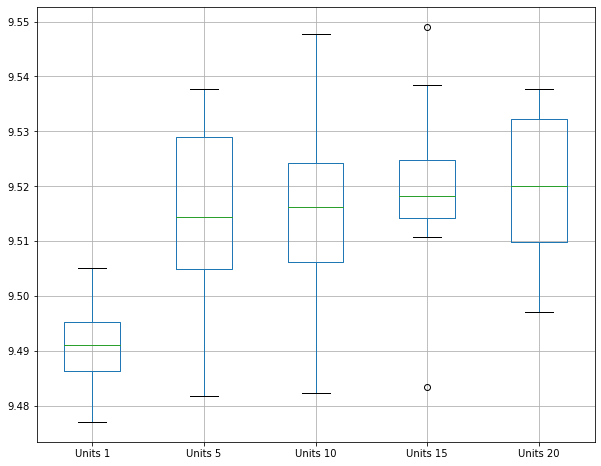

In [181]:
plt.figure( figsize=(10, 8))
VanilaUnitSize_df.boxplot();

In [26]:
BEST_UNIT=1

### 1.1.2 Batch size

In [32]:
VanilaBatchSize_df=pd.DataFrame()
batches=[20,40,60,80,100]

for size in batches:
    errors=list()
    print(f'Batch size: {size}')  
    for index in range(0,10):
        model = Sequential()
        model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=False))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history=model.fit(trainX, trainY, epochs=200, batch_size=size,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_model(model,validateX,validateY,close_scaler,difference_validate_data))

    VanilaBatchSize_df[f'Batch size: {size}']=errors

Batch size: 20
Batch size: 40
Batch size: 60
Batch size: 80
Batch size: 100


In [33]:
VanilaBatchSize_df.describe()

,Batch size: 20,Batch size: 40,Batch size: 60,Batch size: 80,Batch size: 100
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,9.494787,9.479280,9.481160,9.494141,9.482668
std,0.009055,0.012859,0.012787,0.017361,0.019475
min,9.472367,9.454383,9.460859,9.469105,9.450943
25%,9.493210,9.472080,9.476754,9.486365,9.479886
50%,9.496357,9.478338,9.481608,9.491456,9.481590
75%,9.498275,9.487683,9.489951,9.504713,9.487427
max,9.505736,9.500412,9.501725,9.522357,9.517755


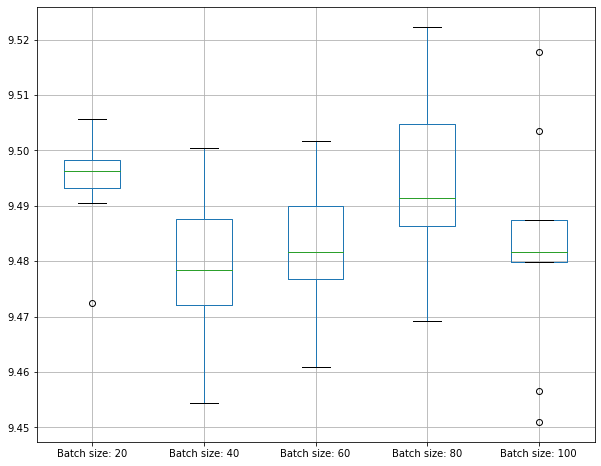

In [34]:
plt.figure( figsize=(10, 8))
VanilaBatchSize_df.boxplot();

In [27]:
BEST_BATCH_SIZE=40

### 1.1.3 Epochs

In [36]:
VanilaEpochsSize_df=pd.DataFrame()
epochs=[100,200,300,400,500]

for epoch in epochs:
    errors=list()
    print(f'Epochs: {epoch}')  
    for index in range(0,10):
        model = Sequential()
        model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=False))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history=model.fit(trainX, trainY, epochs=epoch, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_model(model,validateX,validateY,close_scaler,difference_validate_data))

    VanilaEpochsSize_df[f'Epochs {epoch}']=errors

Epochs: 100
Epochs: 200
Epochs: 300
Epochs: 400
Epochs: 500


In [37]:
VanilaEpochsSize_df.describe()

,Epochs 100,Epochs 200,Epochs 300,Epochs 400,Epochs 500
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,9.493817,9.481343,9.488898,9.501120,9.509628
std,0.029325,0.012840,0.010013,0.017218,0.016682
min,9.457288,9.458037,9.472364,9.473956,9.494868
25%,9.465409,9.477331,9.485860,9.493327,9.499883
50%,9.499173,9.478872,9.488960,9.499227,9.504380
75%,9.513728,9.491056,9.493301,9.509753,9.515097
max,9.534505,9.499005,9.508090,9.536973,9.550944


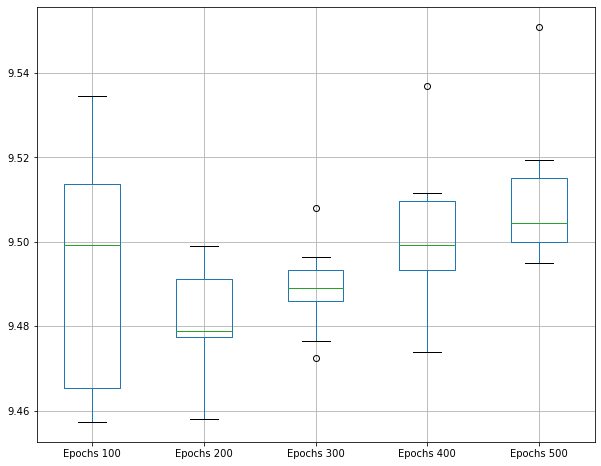

In [38]:
plt.figure( figsize=(10, 8))
VanilaEpochsSize_df.boxplot();

In [28]:
BEST_EPOCHS=200

### 1.1.3 Test best model


In [149]:
model = Sequential()
model.add(LSTM(1, input_shape=(1, STEPS_IN), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history=model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
vanilla_rsme=evaluate_model(model,testX,testY,close_scaler,difference_test_data)
vanilla_rsme

26.014155807852532

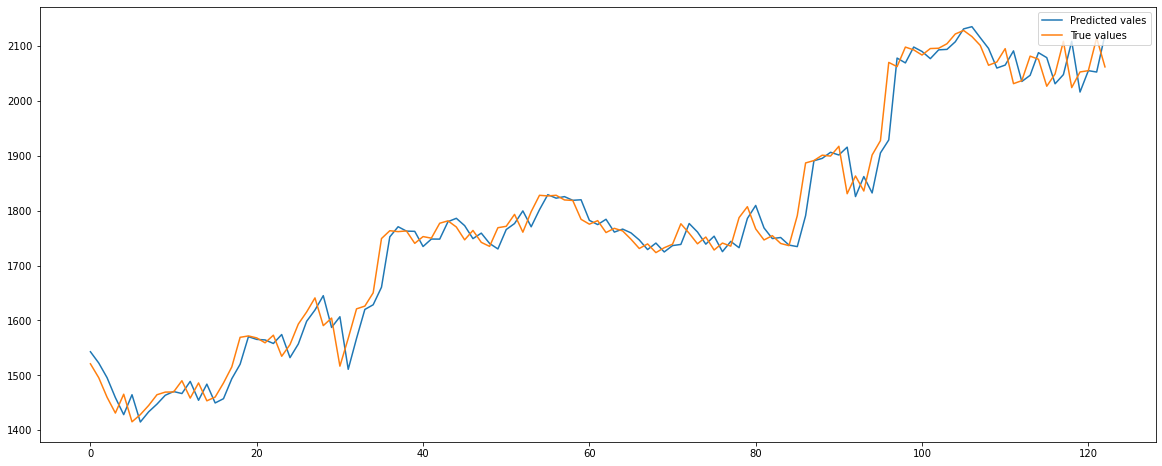

In [151]:
plot_result(model,testX,testY,close_scaler,difference_test_data,650)

In [69]:
RSME_names.append('Vanilla RSME')
RSME_values.append(vanilla_rsme)

## 1.2 Stacked LSTM

### 1.2.1 Number of layers

In [37]:
StackedLayers_df=pd.DataFrame()
layers=[1,2,3,4,5,6,7,8,9]

for layer in layers:
    errors=list()
    print(f'Layers: {layer}')
    for index in range(0,10):
        model = Sequential()
        for l in range(0,layer-1):
            model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=True))
        model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=False))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history=model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_model(model,validateX,validateY,close_scaler,difference_validate_data))

    StackedLayers_df[f'Layers {layer}']=errors

Layers: 1
Layers: 2
Layers: 3
Layers: 4
Layers: 5


In [47]:
StackedLayers_df.describe()

,Layers 1,Layers 2,Layers 3,Layers 4,Layers 5,Layers 6,Layers 7,Layers 8,Layers 9
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,9.481135,9.469957,9.479258,9.469108,9.462124,9.468243,9.467632,9.468013,9.467326
std,0.016185,0.021468,0.025796,0.018984,0.015846,0.008737,0.001327,0.002258,0.000648
min,9.454229,9.437103,9.458108,9.433096,9.438924,9.459827,9.466498,9.466509,9.466544
25%,9.471833,9.451774,9.463241,9.462731,9.451154,9.464780,9.466873,9.466625,9.466728
50%,9.482194,9.474658,9.468160,9.467093,9.462411,9.466672,9.467358,9.467596,9.467359
75%,9.492547,9.483187,9.481189,9.474008,9.474761,9.467311,9.467546,9.468136,9.467756
max,9.506343,9.502355,9.532980,9.504769,9.485801,9.492126,9.471129,9.474108,9.468524


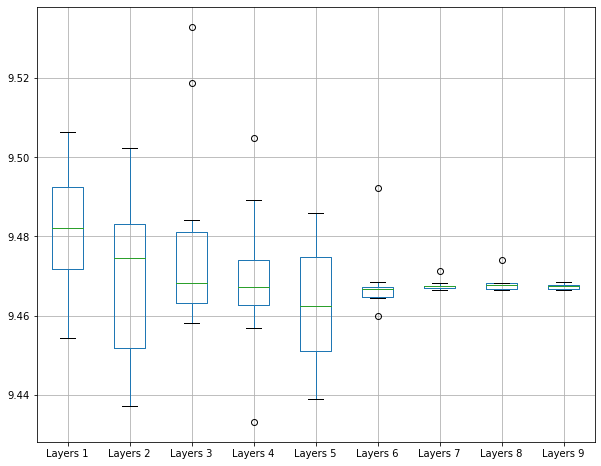

In [48]:
plt.figure( figsize=(10, 8))
StackedLayers_df.boxplot();

In [ ]:
BEST_LAYERS=5

### 1.2.2 Dropout

In [56]:
StackedDropout_df=pd.DataFrame()
dropouts=[0.1,0.2,0.3,0.4]

for dropout in dropouts:
    errors=list()
    print(f'Dropout: {dropout}')
    for index in range(0,10):
        model = Sequential()
        model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=False))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history=model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_model(model,validateX,validateY,close_scaler,difference_validate_data))
        
    StackedDropout_df[f'Dropout: {dropout}']=errors

Dropout: 0.1
Dropout: 0.2
Dropout: 0.3
Dropout: 0.4


In [57]:
StackedDropout_df.describe()

,Dropout: 0.1,Dropout: 0.2,Dropout: 0.3,Dropout: 0.4
count,10.000000,10.000000,10.000000,10.000000
mean,9.458377,9.466015,9.466442,9.466575
std,0.010536,0.001429,0.000473,0.000132
min,9.446049,9.462034,9.465378,9.466414
25%,9.450301,9.466052,9.466429,9.466470
50%,9.455790,9.466608,9.466642,9.466578
75%,9.466300,9.466656,9.466714,9.466628
max,9.477931,9.466689,9.466888,9.466810


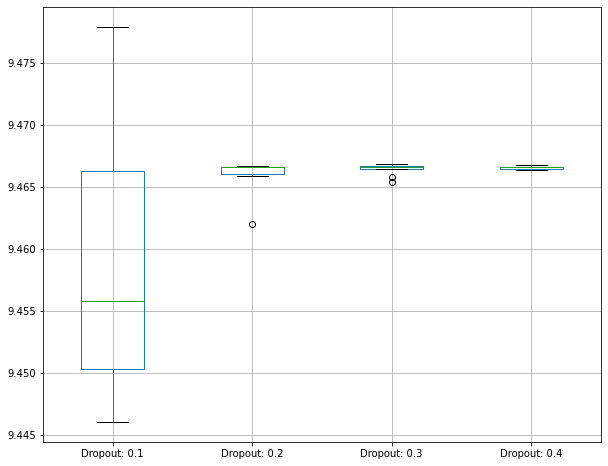

In [58]:
plt.figure( figsize=(10, 8))
StackedDropout_df.boxplot();

In [70]:
BEST_DROPOUT=0.1

### 1.2.3 Best model

In [105]:
model = Sequential()
model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(BEST_UNIT, input_shape=(1, STEPS_IN), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history=model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
stacked_rsme=evaluate_model(model,testX,testY,close_scaler,difference_test_data)
stacked_rsme

25.71093033696399

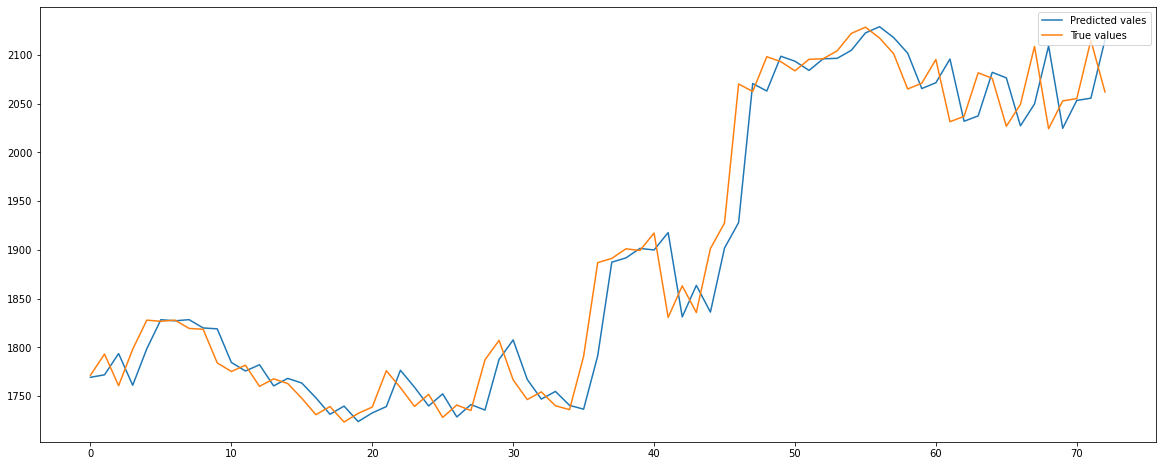

In [106]:
plot_result(model,testX,testY,close_scaler,difference_test_data,700)

In [81]:
RSME_names.append('Stacked RSME')
RSME_values.append(stacked_rsme)

## 1.3 Bidirectional LSTM

### 1.3.1 Number of layers

In [102]:
BidirectionalLayers_df=pd.DataFrame()
layers=[1,2,3,4,5]

for layer in layers:
    errors=list()
    print(f'Layers: {layer}')
    for index in range(0,10):
        model = Sequential()
        for l in range(0,layer-1):
            model.add(Bidirectional(LSTM(BEST_UNIT, return_sequences=True),input_shape=(1, STEPS_IN)))
        model.add(Bidirectional(LSTM(BEST_UNIT, return_sequences=False),input_shape=(1, STEPS_IN)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history=model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_model(model,validateX,validateY,close_scaler,difference_validate_data))

    BidirectionalLayers_df[f'Layers {layer}']=errors

Layers: 1
Layers: 2
Layers: 3
Layers: 4
Layers: 5


In [103]:
BidirectionalLayers_df.describe()

,Layers 1,Layers 2,Layers 3,Layers 4,Layers 5
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,9.492673,9.487264,9.479816,9.477456,9.475059
std,0.013245,0.010336,0.013596,0.011897,0.020240
min,9.474276,9.476401,9.462922,9.459846,9.441430
25%,9.482478,9.479172,9.471463,9.468369,9.461731
50%,9.494009,9.484316,9.476079,9.475732,9.478708
75%,9.498884,9.492713,9.484565,9.487258,9.489643
max,9.512425,9.508090,9.506325,9.496664,9.497562


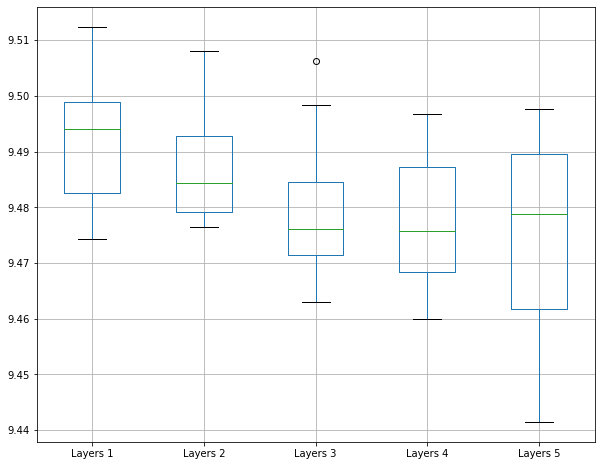

In [104]:
plt.figure( figsize=(10, 8))
BidirectionalLayers_df.boxplot();

1.3.2 Unit size


In [152]:
BidirectionalUnitSize_df=pd.DataFrame()
unit_size=[1,3,5,10]

for unit in unit_size:
    errors=list()
    print(f'Unit: {unit}')
    for index in range(0,10):
        model = Sequential()
        for l in range(0,2):
            model.add(Bidirectional(LSTM(unit, return_sequences=True),input_shape=(1, STEPS_IN)))
        model.add(Bidirectional(LSTM(unit, return_sequences=False),input_shape=(1, STEPS_IN)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history=model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_model(model,validateX,validateY,close_scaler,difference_validate_data))

    BidirectionalUnitSize_df[f'Units {unit}']=errors

Unit: 1
Unit: 3
Unit: 5
Unit: 10


In [153]:
BidirectionalUnitSize_df.describe()

,Units 1,Units 3,Units 5,Units 10
count,10.000000,10.000000,10.000000,10.000000
mean,9.477840,9.497988,9.499351,9.522519
std,0.014645,0.020962,0.011263,0.021682
min,9.460696,9.478086,9.486328,9.499476
25%,9.465071,9.487691,9.490497,9.504307
50%,9.476460,9.493316,9.495260,9.523344
75%,9.489583,9.500943,9.508817,9.529120
max,9.498752,9.552711,9.518341,9.566332


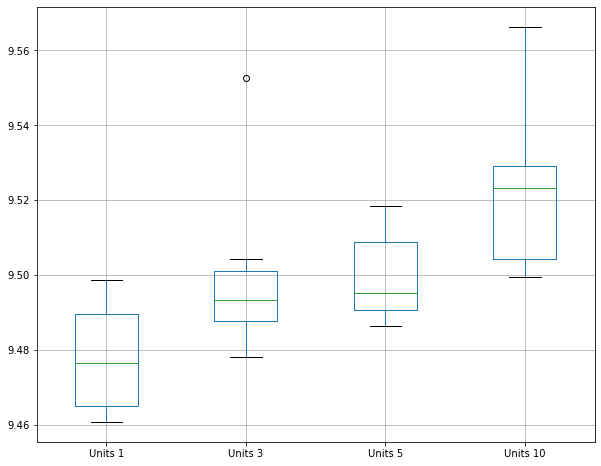

In [154]:
plt.figure( figsize=(10, 8))
BidirectionalUnitSize_df.boxplot();

### 1.3.3 Best model

In [157]:
model = Sequential()
for l in range(0,2):
    model.add(Bidirectional(LSTM(BEST_UNIT, return_sequences=True),input_shape=(1, STEPS_IN)))
model.add(Bidirectional(LSTM(BEST_UNIT, return_sequences=False),input_shape=(1, STEPS_IN)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)

bidirectional_rsme=evaluate_model(model,testX,testY,close_scaler,difference_test_data)
bidirectional_rsme

26.009481376107047

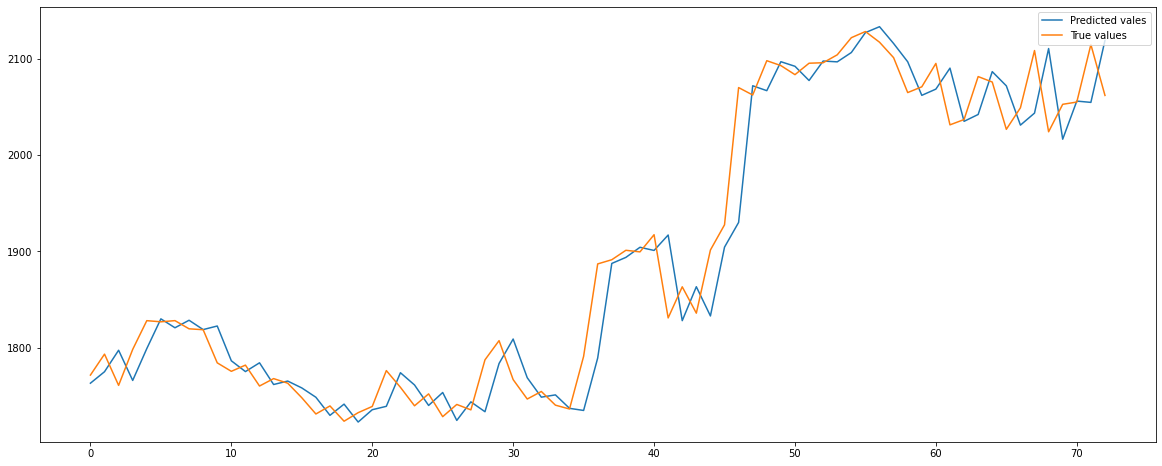

In [162]:
plot_result(model,testX,testY,close_scaler,difference_test_data,700)

In [159]:
RSME_names.append('Bidirectional RSME')
RSME_values.append(bidirectional_rsme)

## 1.4 CNN LSTM (LSTNet)

### Resample data fo CNN

In [164]:
print(STEPS_IN)
print(STEPS_OUT)

30
1


In [165]:
SEQUENCES=10

In [167]:
trainX=np.reshape(trainX,(trainX.shape[0], SEQUENCES, int(STEPS_IN/SEQUENCES), trainX.shape[1]))
validateX=np.reshape(validateX,(validateX.shape[0], SEQUENCES, int(STEPS_IN/SEQUENCES), validateX.shape[1]))
testX = np.reshape(testX,(testX.shape[0], SEQUENCES, int(STEPS_IN/SEQUENCES), testX.shape[1]))

### 1.4.1 Filter size

In [176]:
LSTNetFilterSize_df=pd.DataFrame()
filter_sizes=[8,16,32,64]

for filter in filter_sizes:
    errors=list()
    print(f'Filter size: {filter}')
    for index in range(0,10):
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=filter, kernel_size=1, activation='relu'), input_shape=(None, int(STEPS_IN/SEQUENCES), STEPS_OUT)))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(5, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        history=model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_model(model,validateX,validateY,close_scaler,difference_validate_data))

    LSTNetFilterSize_df[f'Filter size: {filter}']=errors

Filter size: 8
Filter size: 16
Filter size: 32
Filter size: 64


In [177]:
LSTNetFilterSize_df.describe()

,Filter size: 8,Filter size: 16,Filter size: 32,Filter size: 64
count,10.000000,10.000000,10.000000,10.000000
mean,9.475895,9.475861,9.476941,9.473354
std,0.003588,0.005566,0.004250,0.006414
min,9.468360,9.468244,9.468117,9.466056
25%,9.474245,9.471352,9.476187,9.468116
50%,9.476876,9.475148,9.476640,9.471789
75%,9.478631,9.479788,9.478757,9.477929
max,9.479730,9.484531,9.484210,9.485952


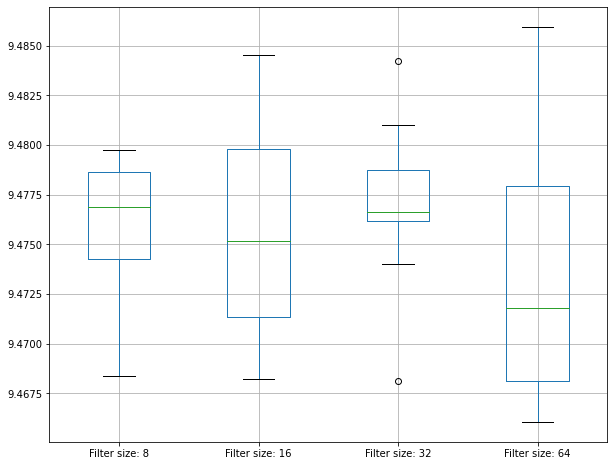

In [178]:
plt.figure( figsize=(10, 8))
LSTNetFilterSize_df.boxplot();

In [179]:
BEST_FILTER=8

### 1.4.2 Kernel size

In [189]:
LSTNetKernelSize_df=pd.DataFrame()
kernel_sizes=[1,2]

for kernel in kernel_sizes:
    errors=list()
    print(f'Kernel size: {kernel}')
    for index in range(0,10):
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=BEST_FILTER, kernel_size=kernel, activation='relu'), input_shape=(None, int(STEPS_IN/SEQUENCES), STEPS_OUT)))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(5, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        history=model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_model(model,validateX,validateY,close_scaler,difference_validate_data))

    LSTNetKernelSize_df[f'Kernel size: {kernel}']=errors

Kernel size: 1
Kernel size: 2


In [190]:
LSTNetKernelSize_df.describe()

,Kernel size: 1,Kernel size: 2
count,10.000000,10.000000
mean,9.476762,9.507603
std,0.005812,0.034061
min,9.468271,9.467100
25%,9.474372,9.483658
50%,9.476702,9.491406
75%,9.479517,9.534429
max,9.488168,9.572052


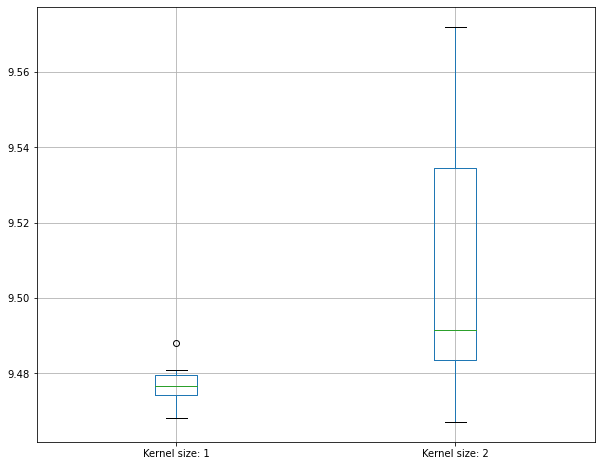

In [191]:
plt.figure( figsize=(10, 8))
LSTNetKernelSize_df.boxplot();

In [192]:
BEST_KERNEL=1

### 1.4.3 Best model

In [193]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=BEST_FILTER, kernel_size=BEST_KERNEL, activation='relu'), input_shape=(None, int(STEPS_IN/SEQUENCES), STEPS_OUT)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(5, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
        
model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)

lstnet_rsme=evaluate_model(model,testX,testY,close_scaler,difference_test_data)
lstnet_rsme

25.73035622964785

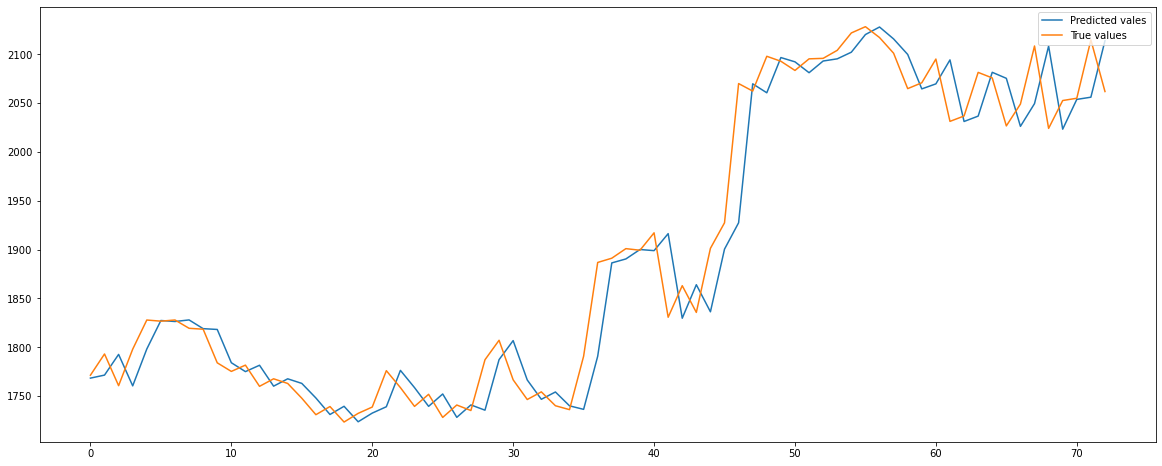

In [194]:
plot_result(model,testX,testY,close_scaler,difference_test_data,700)

In [195]:
RSME_names.append('LSTNet RSME')
RSME_values.append(lstnet_rsme)

## 1.5 Univarate summary

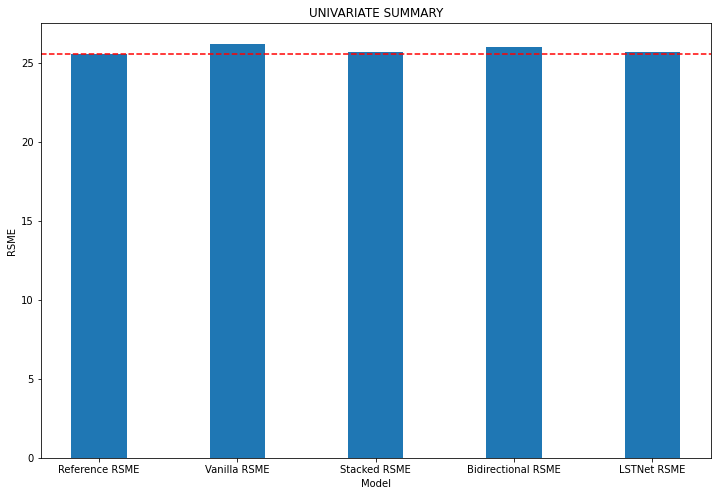

In [205]:
fig = plt.figure(figsize = (12, 8))
 
plt.bar(RSME_names, RSME_values, width = 0.4)
plt.axhline(y=RSME_values[0], color='r', linestyle='--')
plt.xlabel("Model")
plt.ylabel("RSME")
plt.title("UNIVARIATE SUMMARY")
plt.show()

# 2. Multivariate LSTM Model

In [206]:
STEPS_IN=15
STEPS_OUT=1

In [251]:
supervised_train_data=series_to_supervised(train_data.loc[:,['Close_diff','Volume']],STEPS_IN,STEPS_OUT,dropnan=True)
supervised_validate_data=series_to_supervised(validate_data.loc[:,['Close_diff','Volume']],STEPS_IN,STEPS_OUT,dropnan=True)[1:]
supervised_test_data=series_to_supervised(test_data.loc[:,['Close_diff','Volume']],STEPS_IN,STEPS_OUT,dropnan=True)

In [252]:
difference_train_data=create_differencing_reverse(train_data.loc[:,['Close']],STEPS_IN,STEPS_OUT)
difference_validate_data=create_differencing_reverse(validate_data.loc[:,['Close']],STEPS_IN,STEPS_OUT)
difference_test_data=create_differencing_reverse(test_data.loc[:,['Close']],STEPS_IN,STEPS_OUT)

In [253]:
trainX=supervised_train_data.iloc[:,:2*STEPS_IN].to_numpy().reshape(-1,2*STEPS_IN)
trainY=supervised_train_data.iloc[:,2*STEPS_IN:2*(STEPS_IN+STEPS_OUT)-1].to_numpy().reshape(-1,2*STEPS_OUT-1)

In [254]:
testX=supervised_test_data.iloc[:,:2*STEPS_IN].to_numpy().reshape(-1,2*STEPS_IN)
testY=supervised_test_data.iloc[:,2*STEPS_IN:2*(STEPS_IN+STEPS_OUT)-1].to_numpy().reshape(-1,2*STEPS_OUT-1)

In [255]:
validateX=supervised_validate_data.iloc[:,:2*STEPS_IN].to_numpy().reshape(-1,2*STEPS_IN)
validateY=supervised_validate_data.iloc[:,2*STEPS_IN:2*(STEPS_IN+STEPS_OUT)-1].to_numpy().reshape(-1,2*STEPS_OUT-1)

In [256]:
trainX = np.reshape(trainX, (trainX.shape[0], STEPS_IN, 2))
validateX=np.reshape(validateX, (validateX.shape[0], STEPS_IN, 2))
testX = np.reshape(testX, (testX.shape[0], STEPS_IN, 2))

## 2.1 Stacked LSTM

### 2.1.1 Number of layers

In [258]:
MultivariateLayers_df=pd.DataFrame()
layers=[1,2,3,4,5]

for layer in layers:
    errors=list()
    print(f'Layers: {layer}')
    for index in range(0,10):
        model = Sequential()
        for l in range(0,layer-1):
            model.add(LSTM(5, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=True))
        model.add(LSTM(5, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history=model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_model(model,validateX,validateY,close_scaler,difference_validate_data))

    MultivariateLayers_df[f'Layers {layer}']=errors

Layers: 1
Layers: 2
Layers: 3
Layers: 4
Layers: 5


In [259]:
MultivariateLayers_df.describe()

,Layers 1,Layers 2,Layers 3,Layers 4,Layers 5
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,9.506596,9.504681,9.508287,9.508770,9.508282
std,0.006567,0.005369,0.003695,0.004208,0.001942
min,9.492626,9.496976,9.500967,9.500085,9.504445
25%,9.504231,9.502357,9.505948,9.507014,9.507873
50%,9.506490,9.503386,9.508930,9.508619,9.508853
75%,9.511531,9.507086,9.511535,9.511737,9.509355
max,9.515428,9.514416,9.511859,9.513839,9.510581


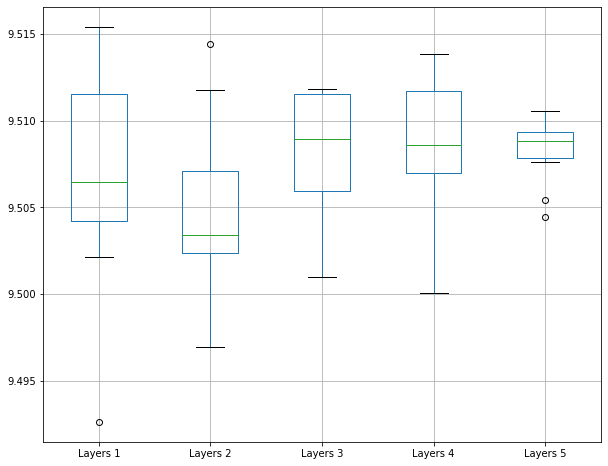

In [260]:
plt.figure( figsize=(10, 8))
MultivariateLayers_df.boxplot();

### 2.1.2 Number of units

In [261]:
MultivariateUnits_df=pd.DataFrame()
units=[1,4,8,12]

for unit in units:
    errors=list()
    print(f'Units: {unit}')
    for index in range(0,10):
        model = Sequential()
        model.add(LSTM(unit, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=True))
        model.add(LSTM(unit, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history=model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_model(model,validateX,validateY,close_scaler,difference_validate_data))

    MultivariateUnits_df[f'Units {unit}']=errors

Units: 1
Units: 4
Units: 8
Units: 12


In [262]:
MultivariateUnits_df.describe()

,Units 1,Units 4,Units 8,Units 12
count,10.000000,10.000000,10.000000,10.000000
mean,9.489938,9.506897,9.506711,9.503185
std,0.011934,0.005152,0.004433,0.001710
min,9.475608,9.497877,9.500692,9.500836
25%,9.480278,9.505407,9.503216,9.502023
50%,9.488487,9.507848,9.506491,9.502960
75%,9.494312,9.509212,9.509611,9.503472
max,9.511482,9.514407,9.514377,9.506490


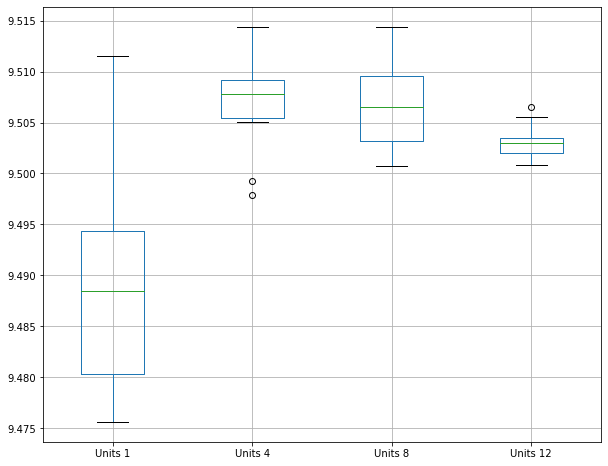

In [263]:
plt.figure( figsize=(10, 8))
MultivariateUnits_df.boxplot();

In [265]:
model = Sequential()
model.add(LSTM(BEST_UNIT, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LSTM(BEST_UNIT, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)

multivariate_rsme=evaluate_model(model,testX,testY,close_scaler,difference_test_data)
multivariate_rsme

25.797700235987225

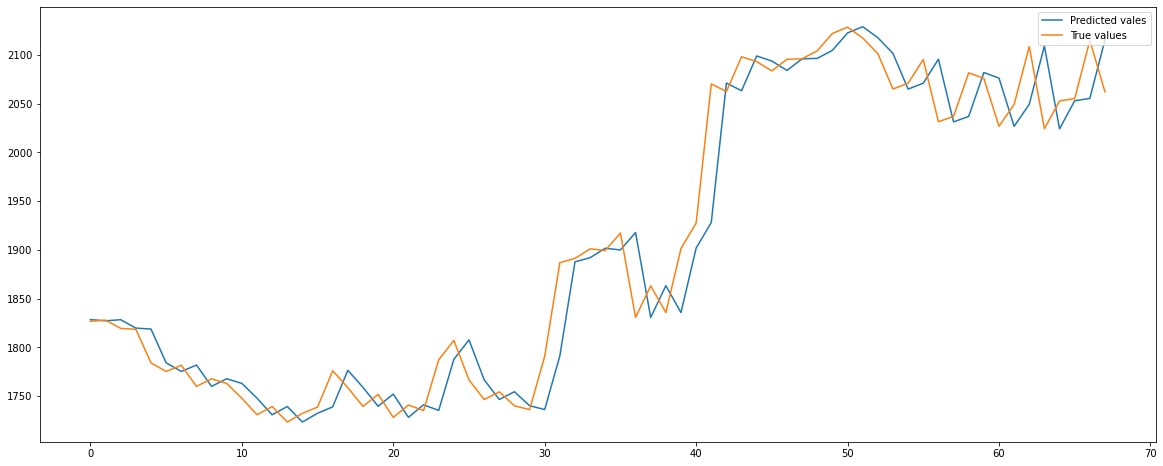

In [274]:
plot_result(model,testX,testY,close_scaler,difference_test_data,720)

## 2.2 Summary

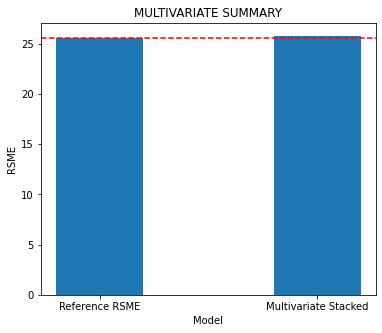

In [272]:
fig = plt.figure(figsize = (6, 5))
 
plt.bar(['Reference RSME','Multivariate Stacked'], [REF_RSME,multivariate_rsme], width = 0.4)
plt.axhline(y=REF_RSME, color='r', linestyle='--')
plt.xlabel("Model")
plt.ylabel("RSME")
plt.title("MULTIVARIATE SUMMARY")
plt.show()

# 3. Multi-Step LSTM Models

In [275]:
STEPS_IN=30
STEPS_OUT=5

In [276]:
supervised_train_data=series_to_supervised(train_data.loc[:,['Close_diff']],STEPS_IN,STEPS_OUT,dropnan=True)
supervised_validate_data=series_to_supervised(validate_data.loc[:,['Close_diff']],STEPS_IN,STEPS_OUT,dropnan=True)[1:]
supervised_test_data=series_to_supervised(test_data.loc[:,['Close_diff']],STEPS_IN,STEPS_OUT,dropnan=True)

In [277]:
difference_train_data=create_differencing_reverse(train_data.loc[:,['Close']],STEPS_IN,STEPS_OUT)
difference_validate_data=create_differencing_reverse(validate_data.loc[:,['Close']],STEPS_IN,STEPS_OUT)
difference_test_data=create_differencing_reverse(test_data.loc[:,['Close']],STEPS_IN,STEPS_OUT)

In [278]:
trainX=supervised_train_data.iloc[:,:STEPS_IN].to_numpy().reshape(-1,STEPS_IN)
trainY=supervised_train_data.iloc[:,STEPS_IN:STEPS_IN+STEPS_OUT].to_numpy().reshape(-1,STEPS_OUT)

In [279]:
testX=supervised_test_data.iloc[:,:STEPS_IN].to_numpy().reshape(-1,STEPS_IN)
testY=supervised_test_data.iloc[:,STEPS_IN:STEPS_IN+STEPS_OUT].to_numpy().reshape(-1,STEPS_OUT)

In [280]:
validateX=supervised_validate_data.iloc[:,:STEPS_IN].to_numpy().reshape(-1,STEPS_IN)
validateY=supervised_validate_data.iloc[:,STEPS_IN:STEPS_IN+STEPS_OUT].to_numpy().reshape(-1,STEPS_OUT)

In [281]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validateX=np.reshape(validateX, (validateX.shape[0], 1, validateX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [351]:
MultiStepREF=list()
for index in range(0,STEPS_OUT):
    MultiStepREF.append(math.sqrt(mean_squared_error(test_data['Close'].values[index+1:], test_data['Close'].values[:-(index+1)])))

## 3.1 Stacked LSTM

### 3.1.1 Number of layers

In [304]:
MultiStepLayers_df=pd.DataFrame()
layers=[1,2,3,4,5]

for layer in layers:
    errors=list()
    print(f'Layers: {layer}')
    for index in range(0,10):
        model = Sequential()
        for l in range(0,layer-1):
            model.add(LSTM(5, return_sequences=True, input_shape=(1,STEPS_IN)))
        model.add(LSTM(5, return_sequences=False, input_shape=(1,STEPS_IN)))
        model.add(Dense(STEPS_OUT))
        model.compile(loss='mean_squared_error', optimizer='adam')

        model.fit(trainX, trainY, epochs=BEST_EPOCHS, batch_size=BEST_BATCH_SIZE,verbose=0,shuffle=False)
        model.reset_states()

        errors.append(evaluate_multistep_model(model,validateX,validateY,close_scaler,difference_validate_data,STEPS_OUT))

    MultiStepLayers_df[f'Layers {layer}']=errors

Layers: 1
Layers: 2
Layers: 3
Layers: 4
Layers: 5


In [348]:
MultiStepResult=list()
for column in MultiStepLayers_df.columns:
    MultiStepResult.append(np.mean(MultiStepLayers_df[column].values.tolist(),axis=0).tolist())

In [349]:
df = pd.DataFrame(MultiStepResult, columns=['Step 0', 'Step 1','Step 2', 'Step 3', 'Step 4'],index=MultiStepLayers_df.columns)
df

,Step 0,Step 1,Step 2,Step 3,Step 4
Layers 1,9.532045,9.515915,9.520941,9.500579,9.472938
Layers 2,9.506274,9.511448,9.504434,9.481504,9.472200
Layers 3,9.492102,9.495925,9.506284,9.481134,9.471018
Layers 4,9.493165,9.496288,9.501879,9.484548,9.459286
Layers 5,9.491157,9.491148,9.498739,9.478182,9.457009


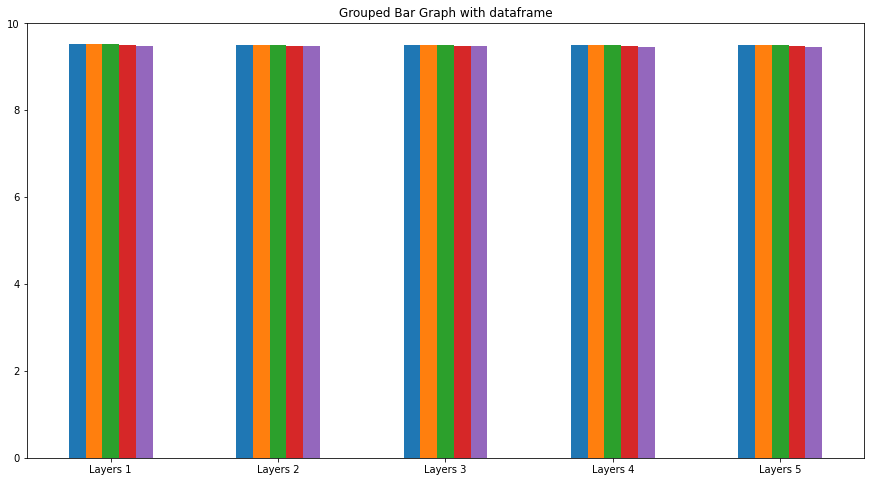

In [350]:
df.plot(kind='bar', stacked=False, title='Grouped Bar Graph with dataframe',figsize=(15,8),rot=0,legend=False) ;

## 3.2 Summary

In [358]:
eval=evaluate_multistep_model(model,testX,testY,close_scaler,difference_test_data,STEPS_OUT)

In [359]:
df = pd.DataFrame([MultiStepREF,eval], columns=['Step 0', 'Step 1','Step 2', 'Step 3', 'Step 4'],index=['REF','Stacked'])
df

,Step 0,Step 1,Step 2,Step 3,Step 4
REF,25.583675,33.50881,40.594241,46.634123,52.146069
Stacked,25.579976,25.55946,25.621336,25.729855,25.831230


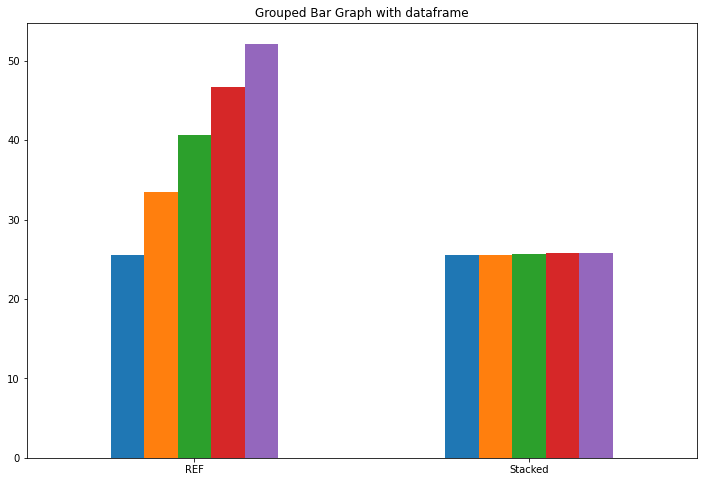

In [361]:
df.plot(kind='bar', stacked=False, title='Grouped Bar Graph with dataframe',figsize=(12,8),rot=0,legend=False) ;

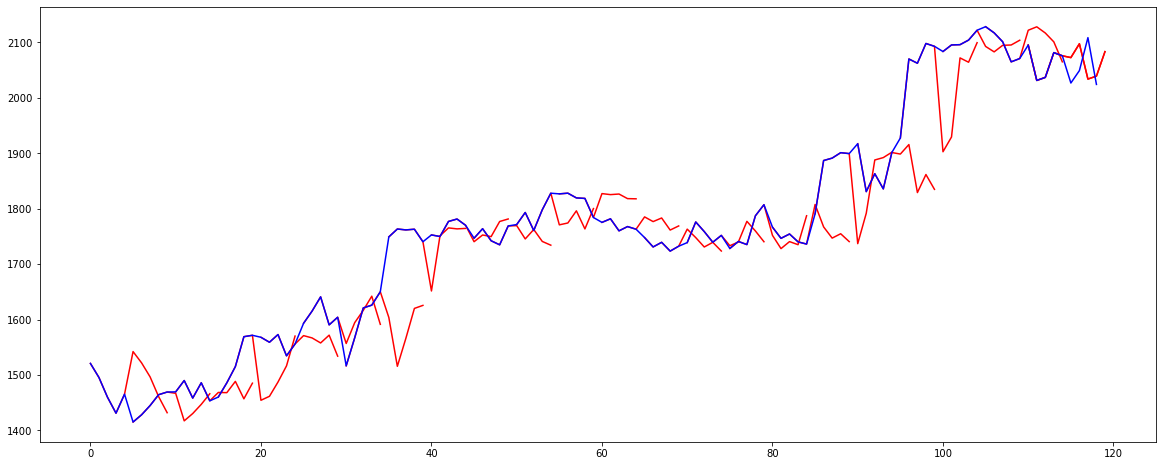

In [430]:
plot_multistep_result(model,testX,testY,close_scaler,difference_test_data,skip=130,step_out=STEPS_OUT)